# Using Ivy ResNet

Use the Ivy `ResNet` model for image classification.

If you already have `Ivy` and `Ivy Models` installed you can skip this cell, but if you are using Colab, you will have to install `Ivy` and `Ivy Models` manually. You can do so by running the cell below ⬇️

In [1]:
!pip install -q ivy

# Using a stable commit from models repository to ensure compatibility with Ivy 😄
!pip install -q git+https://github.com/unifyai/models.git@6d6deebcebb191788a0f6e067b0a10871ce65d1c

!python3 -m pip install torchvision

exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.4 MB/s eta 0:00:00
Cloning into 'models'...
remote: Enumerating objects: 1481, done.
remote: Counting objects: 100% (573/573), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 1481 (delta 383), reused 436 (delta 290), pack-reused 908
Receiving objects: 100% (1481/1481), 287.11 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (737/737), done.
  Preparing metadata (setup.py) ... done


## Imports

In [1]:
import ivy
import torch

## Data Preparation

### Prepare the set of labels

To show the predicted category, we download the labels associated with the pretrained weights.

In [2]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-07-10 08:52:54--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-07-10 08:52:55 (24.2 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



The labels are then loaded into a Python list.

In [3]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

### Load the image example 🖼️

In [4]:
filename = "models/images/cat.jpg"

In [5]:
# Preprocess torch image
from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)])
torch_img = Image.open(filename)
torch_img = preprocess(torch_img)
torch_img = torch.unsqueeze(torch_img, 0)

In [6]:
# Convert to numpy
img = torch_img.permute((0, 2, 3, 1)).detach().numpy()

### Visualise image

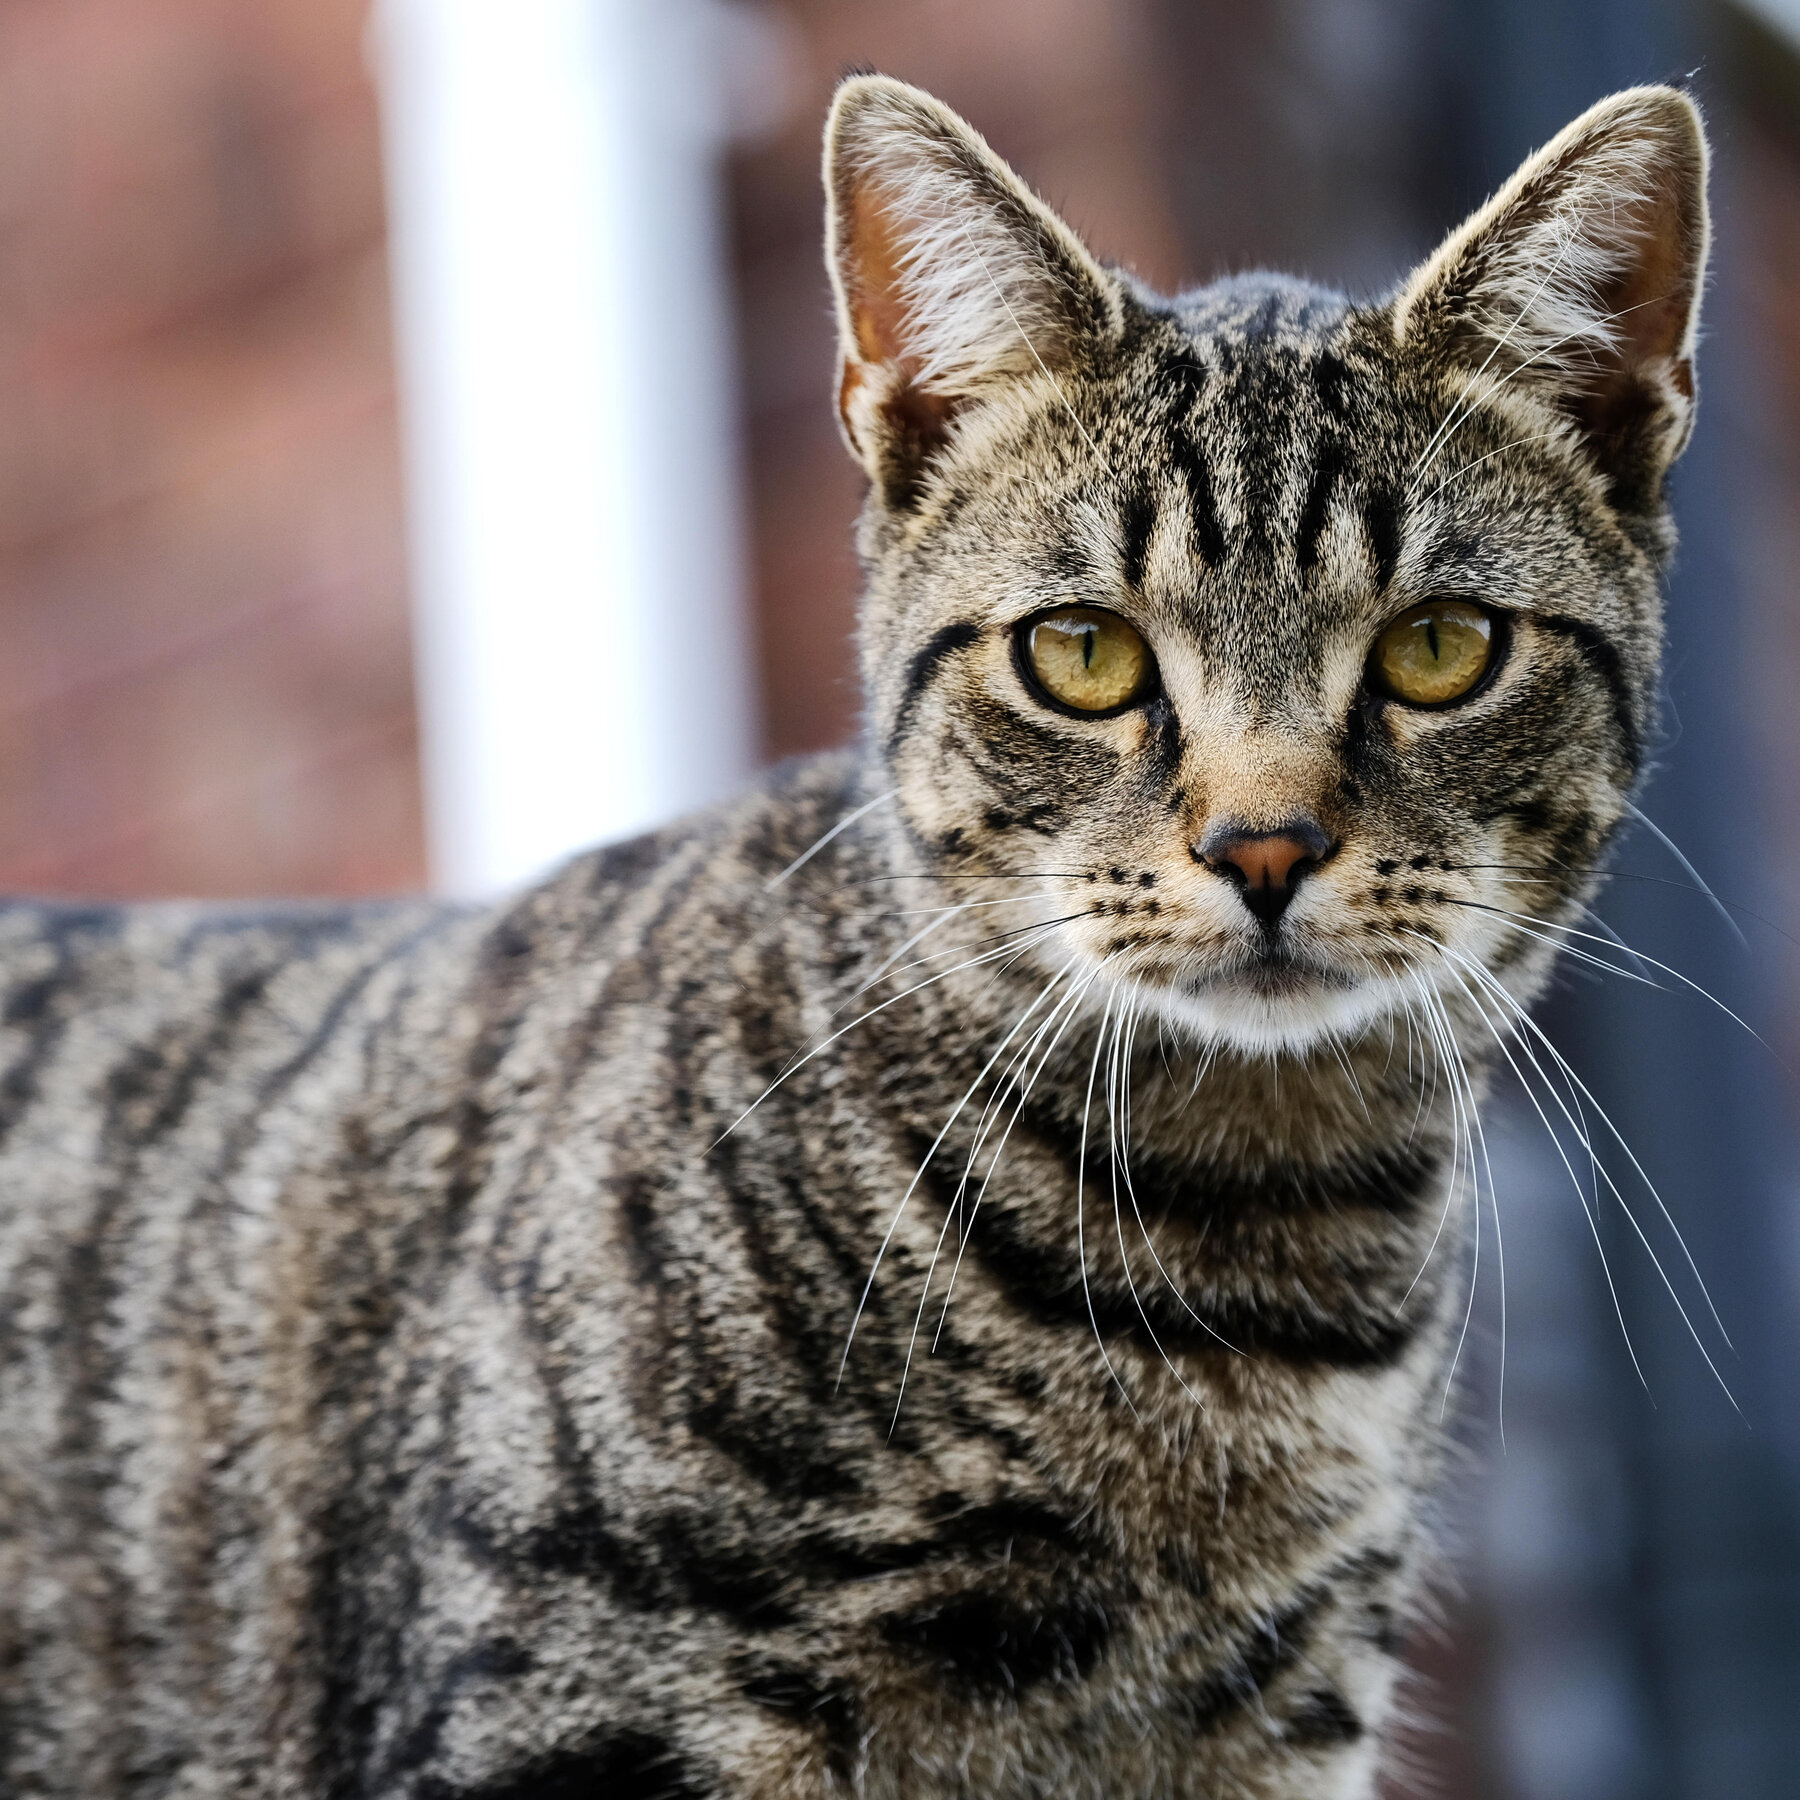

In [7]:
from IPython.display import Image, display
display(Image(filename))

## Model Inference ResNet34



### Initializing Native Torch ResNet34

In [8]:
from torchvision.models import resnet34, ResNet34_Weights
torch_resnet_34 = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
torch_resnet_34.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 98.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Initializing Ivy ResNet34 with Pretrained Weights ⬇️

The model is then initialized with the Pretrained Weights when `pretrained=True` 🔗.

In [9]:
# load the resnet34 model from ivy_models
from ivy_models.resnet import resnet_34
ivy_resnet_34 = resnet_34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 129MB/s]


Compile the forward pass for efficiency.

In [10]:
ivy.set_backend('torch')
ivy_resnet_34.compile(args=(img,))

### Use the model to classify your images 🚀

For comparison, both results from `Torch ResNet34` and `Ivy ResNet34` are shown below.

1. Torch ResNet34

In [11]:
torch_output = torch.softmax(torch_resnet_34(torch_img), dim=1)
torch_classes = torch.argsort(torch_output[0], descending=True)[:3]
torch_logits = torch.take(torch_output[0], torch_classes)

print("Indices of the top 3 classes are:", torch_classes)
print("Logits of the top 3 classes are:", torch_logits)
print("Categories of the top 3 classes are:", [categories[i] for i in torch_classes])

Indices of the top 3 classes are: tensor([282, 281, 285])
Logits of the top 3 classes are: tensor([0.8507, 0.1351, 0.0069], grad_fn=<TakeBackward0>)
Categories of the top 3 classes are: ['tiger cat', 'tabby', 'Egyptian cat']


2. Ivy ResNet34

In [12]:
output = ivy.softmax(ivy_resnet_34(ivy.asarray(img)))  # pass the image to the model
classes = ivy.argsort(output[0], descending=True)[:3]  # get the top 3 classes
logits = ivy.gather(output[0], classes)  # get the logits

print("Indices of the top 3 classes are:", classes)
print("Logits of the top 3 classes are:", logits)
print("Categories of the top 3 classes are:", [categories[i] for i in classes.to_list()])

Indices of the top 3 classes are: ivy.array([282, 281, 285])
Logits of the top 3 classes are: ivy.array([0.85072654, 0.13506071, 0.00688289])
Categories of the top 3 classes are: ['tiger cat', 'tabby', 'Egyptian cat']


## Model Inference ResNet50

### Initializing Native Torch ResNet50

In [13]:
from torchvision.models import resnet50, ResNet50_Weights
torch_resnet_50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
torch_resnet_50.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Initializing Ivy ResNet50 with Pretrained Weights ⬇️

The model is then initialized with the Pretrained Weights when `pretrained=True` 🔗.

In [14]:
# load the resnet50 model from ivy_models
from ivy_models.resnet import resnet_50
ivy_resnet_50 = resnet_50(pretrained=True)

Compile the forward pass for efficiency.

In [15]:
ivy.set_backend('torch')
ivy_resnet_50.compile(args=(img,))

### Use the model to classify your images 🚀

For comparison, both results from `Torch ResNet50` and `Ivy ResNet50` are shown below.

1. Torch ResNet50

In [16]:
torch_output = torch.softmax(torch_resnet_50(torch_img), dim=1)
torch_classes = torch.argsort(torch_output[0], descending=True)[:3]
torch_logits = torch.take(torch_output[0], torch_classes)

print("Indices of the top 3 classes are:", torch_classes)
print("Logits of the top 3 classes are:", torch_logits)
print("Categories of the top 3 classes are:", [categories[i] for i in torch_classes])

Indices of the top 3 classes are: tensor([282, 281, 285])
Logits of the top 3 classes are: tensor([0.3429, 0.0408, 0.0121], grad_fn=<TakeBackward0>)
Categories of the top 3 classes are: ['tiger cat', 'tabby', 'Egyptian cat']


2. Ivy ResNet50

In [17]:
output = ivy.softmax(ivy_resnet_50(ivy.asarray(img)))  # pass the image to the model
classes = ivy.argsort(output[0], descending=True)[:3]  # get the top 3 classes
logits = ivy.gather(output[0], classes)  # get the logits

print("Indices of the top 3 classes are:", classes)
print("Logits of the top 3 classes are:", logits)
print("Categories of the top 3 classes are:", [categories[i] for i in classes.to_list()])

Indices of the top 3 classes are: ivy.array([282, 281, 285])
Logits of the top 3 classes are: ivy.array([0.34288239, 0.04077011, 0.01212029])
Categories of the top 3 classes are: ['tiger cat', 'tabby', 'Egyptian cat']
